In [5]:
import math
import random
from collections.abc import Iterable, MutableMapping
from typing import Any

import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.formats.style import Styler

import pysorteddict
import sortedcontainers

sorted_dict_lens = [100, 1_000, 10_000, 100_000, 1_000_000, 10_000_000]
sorted_dict_types = [pysorteddict.SortedDict, sortedcontainers.SortedDict]


def setup(sorted_dict_type: type, sorted_dict_len: int, seed: float = math.pi) -> MutableMapping:
    random.seed(seed)
    d = sorted_dict_type()
    for _ in range(sorted_dict_len):
        d[random.random()] = random.random()
    return d


def plot(stylers: Iterable[Styler], *, alpha: float = 0.7, logy: bool = False, name: str = "", yunit: str = "s"):
    for theme in ["light", "dark"]:
        with plt.style.context(f"{theme}.mplstyle", after_reset=True):
            fig, ax = plt.subplots()
            lines_in_plot = 0
            for styler, loc in zip(stylers, ["upper left", "lower right"]):
                styler.data.plot(
                    alpha=alpha,
                    ax=ax,
                    logx=True,
                    logy=logy,
                    xlabel="Sorted Dictionary Length",
                    xlim=(sorted_dict_lens[0] // 10, sorted_dict_lens[-1] * 10),
                    ylabel="Average Execution Time",
                )
                # Create a separate legend for these lines.
                font_prop = {"family": "JetBrains Mono"}
                ax.add_artist(
                    ax.legend(
                        handles=ax.lines[lines_in_plot:], loc=loc, prop=font_prop, title=styler.caption, title_fontproperties=font_prop,
                    ),
                )
                lines_in_plot += len(styler.data.columns)
            ax.grid(which="major", linewidth=0.5, linestyle=":")
            ax.grid(which="minor", axis="y", linewidth=0.0625, linestyle="-")
            ax.minorticks_on()
            # The warning about setting labels without setting ticks can be ignored because the plot isn't interactive.
            ax.set_yticklabels(f"{label.get_text()} {yunit}" for label in ax.get_yticklabels())
            plt.show()
            # fig.savefig(f"../../docs/_static/images/perf-{name}-{theme}.svg")

# `contains`

In [6]:
def bench_contains() -> Iterable[Styler]:
    for sorted_dict_type in sorted_dict_types:
        df = pd.DataFrame(index=sorted_dict_lens, columns=["0.00 in d", "0.33 in d", "0.67 in d", "1.00 in d"])
        for i, sorted_dict_len in enumerate(sorted_dict_lens):
            d = setup(sorted_dict_type, sorted_dict_len)
            for j, key in enumerate([0.00, 0.33, 0.67, 1.00]):
                %timeit -v bench key in d
                df.iat[i, j] = bench.average * 1e9
        yield df.style.set_caption(sorted_dict_type.__module__)


stylers = [*bench_contains()]

36.3 ns ± 0.356 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
45 ns ± 0.72 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
39.5 ns ± 0.411 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
30.1 ns ± 0.733 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
48.7 ns ± 0.66 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
60.2 ns ± 0.518 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
56.2 ns ± 0.625 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
59.7 ns ± 0.908 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
21 ns ± 0.247 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
19.7 ns ± 0.0259 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)
22.1 ns ± 0.449 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
20.9 ns ± 0.404 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
22 ns ± 0.371 ns per loop (mean ± std. dev. 

,0.00 in d,0.33 in d,0.67 in d,1.00 in d
100,36.278995,44.978730,39.531799,30.105212
1000,48.675839,60.216288,56.162069,59.736368
10000,nan,nan,nan,nan
100000,nan,nan,nan,nan
1000000,nan,nan,nan,nan
10000000,nan,nan,nan,nan


,0.00 in d,0.33 in d,0.67 in d,1.00 in d
100,21.019646,19.728626,22.051216,20.914245
1000,21.986087,20.899580,23.057784,21.899212
10000,nan,nan,nan,nan
100000,nan,nan,nan,nan
1000000,nan,nan,nan,nan
10000000,nan,nan,nan,nan


/tmp/ipykernel_41982/1239611904.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(f"{label.get_text()} {yunit}" for label in ax.get_yticklabels())


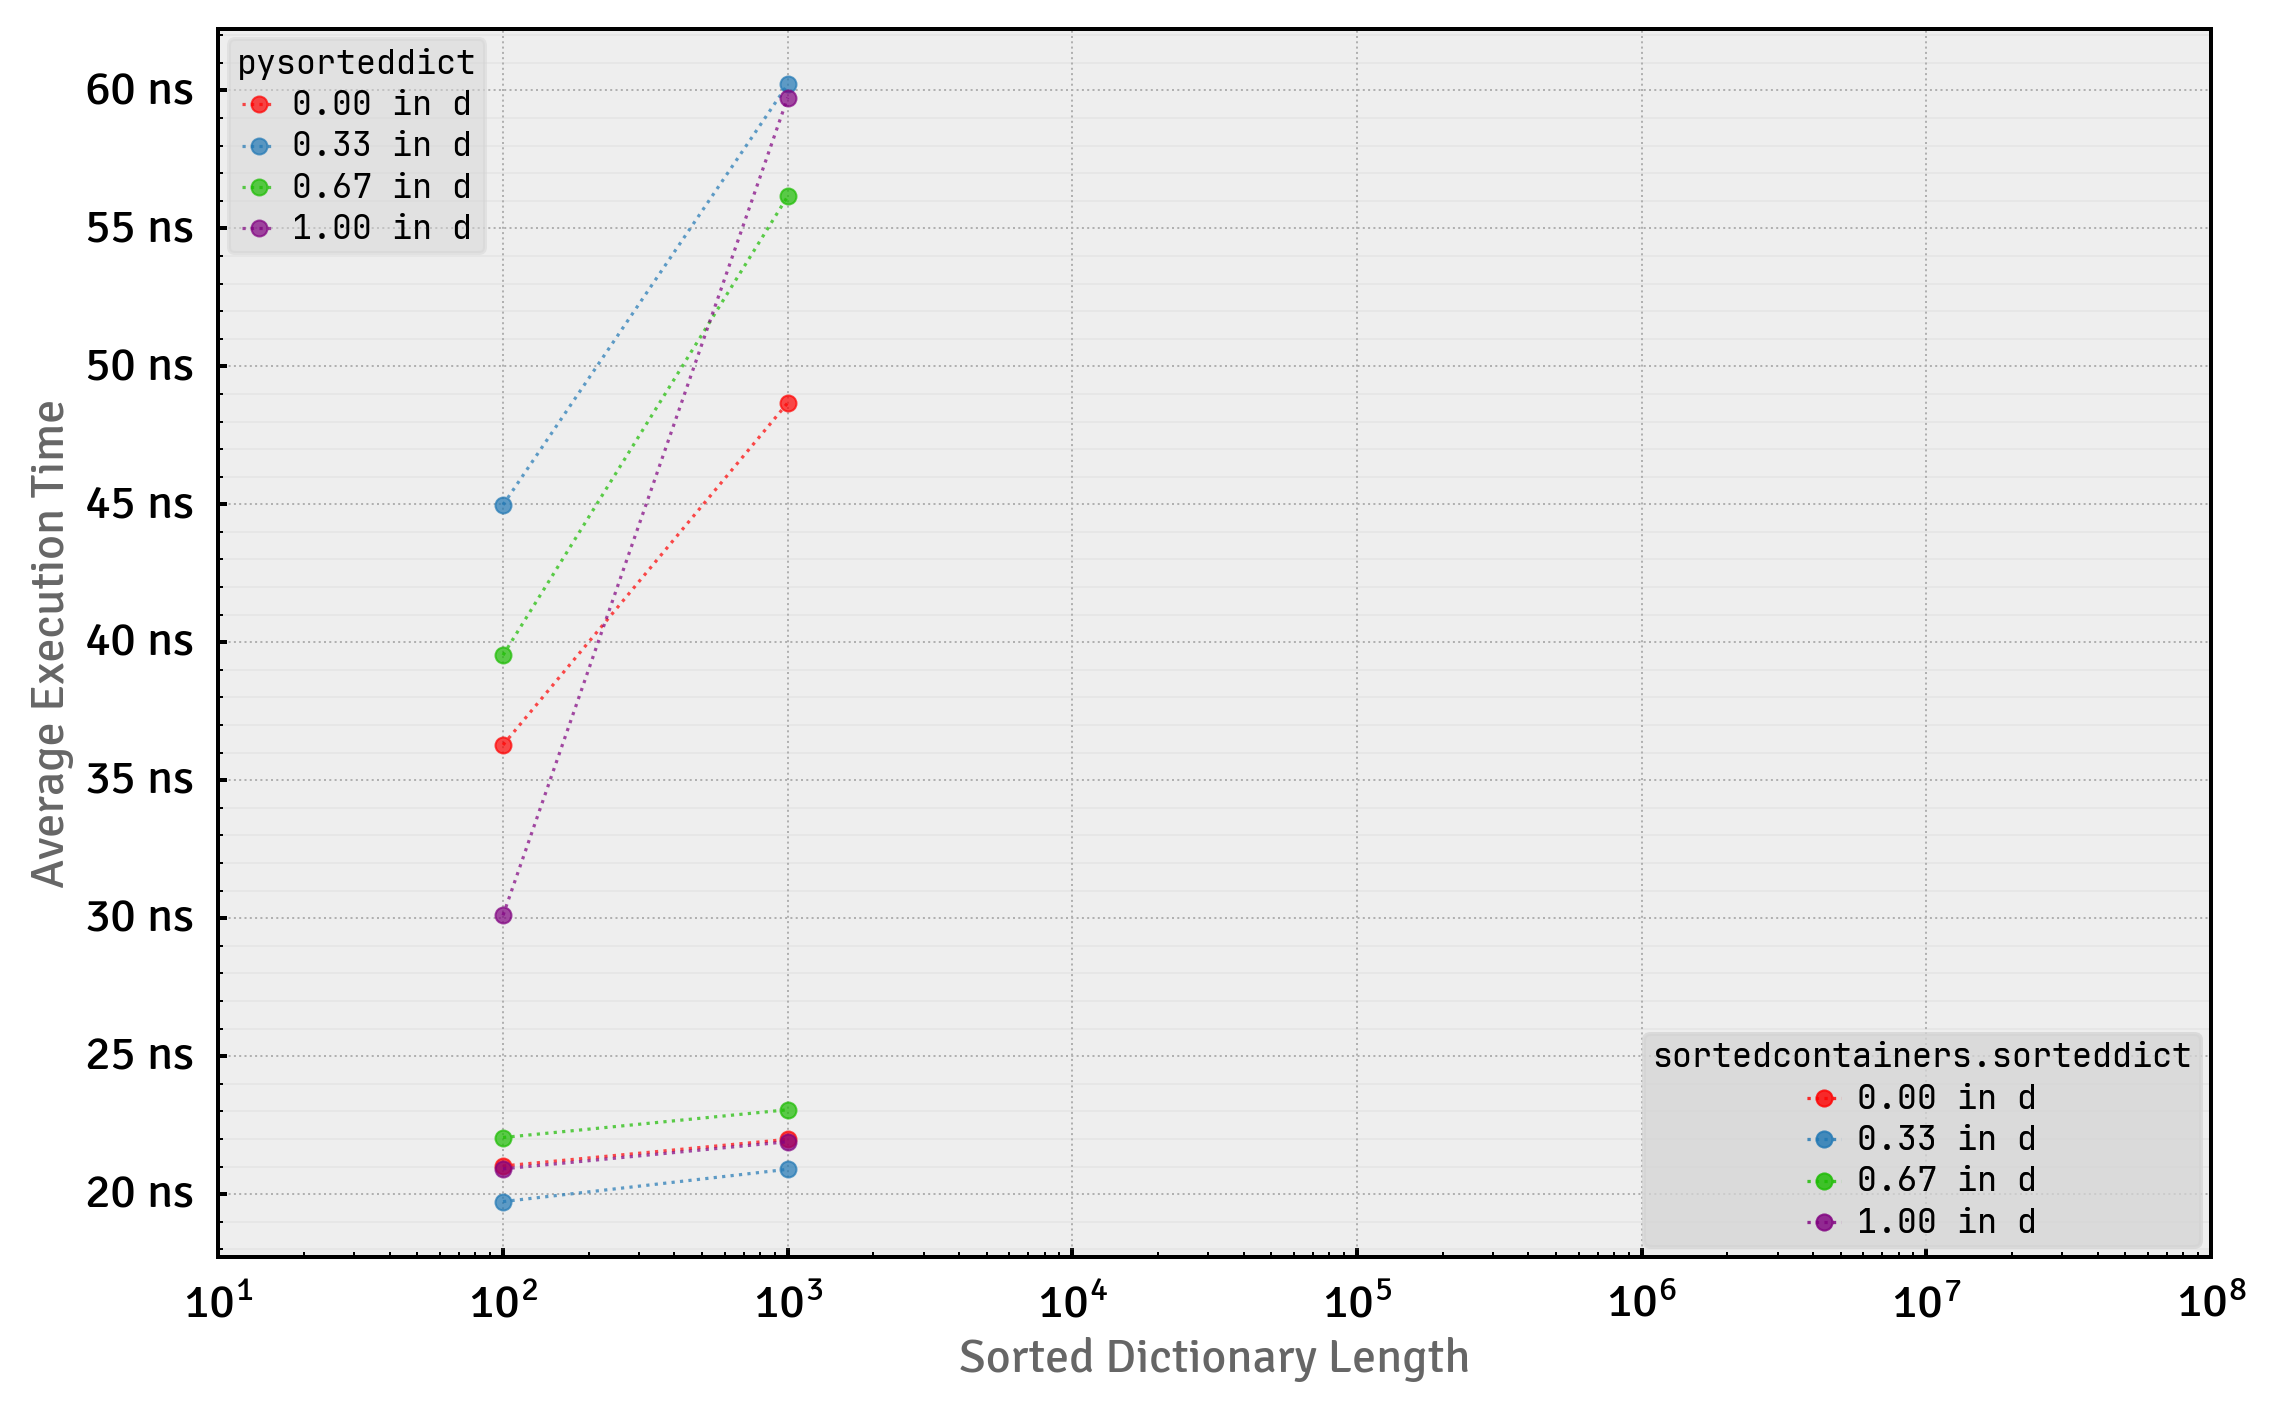

/tmp/ipykernel_41982/1239611904.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(f"{label.get_text()} {yunit}" for label in ax.get_yticklabels())


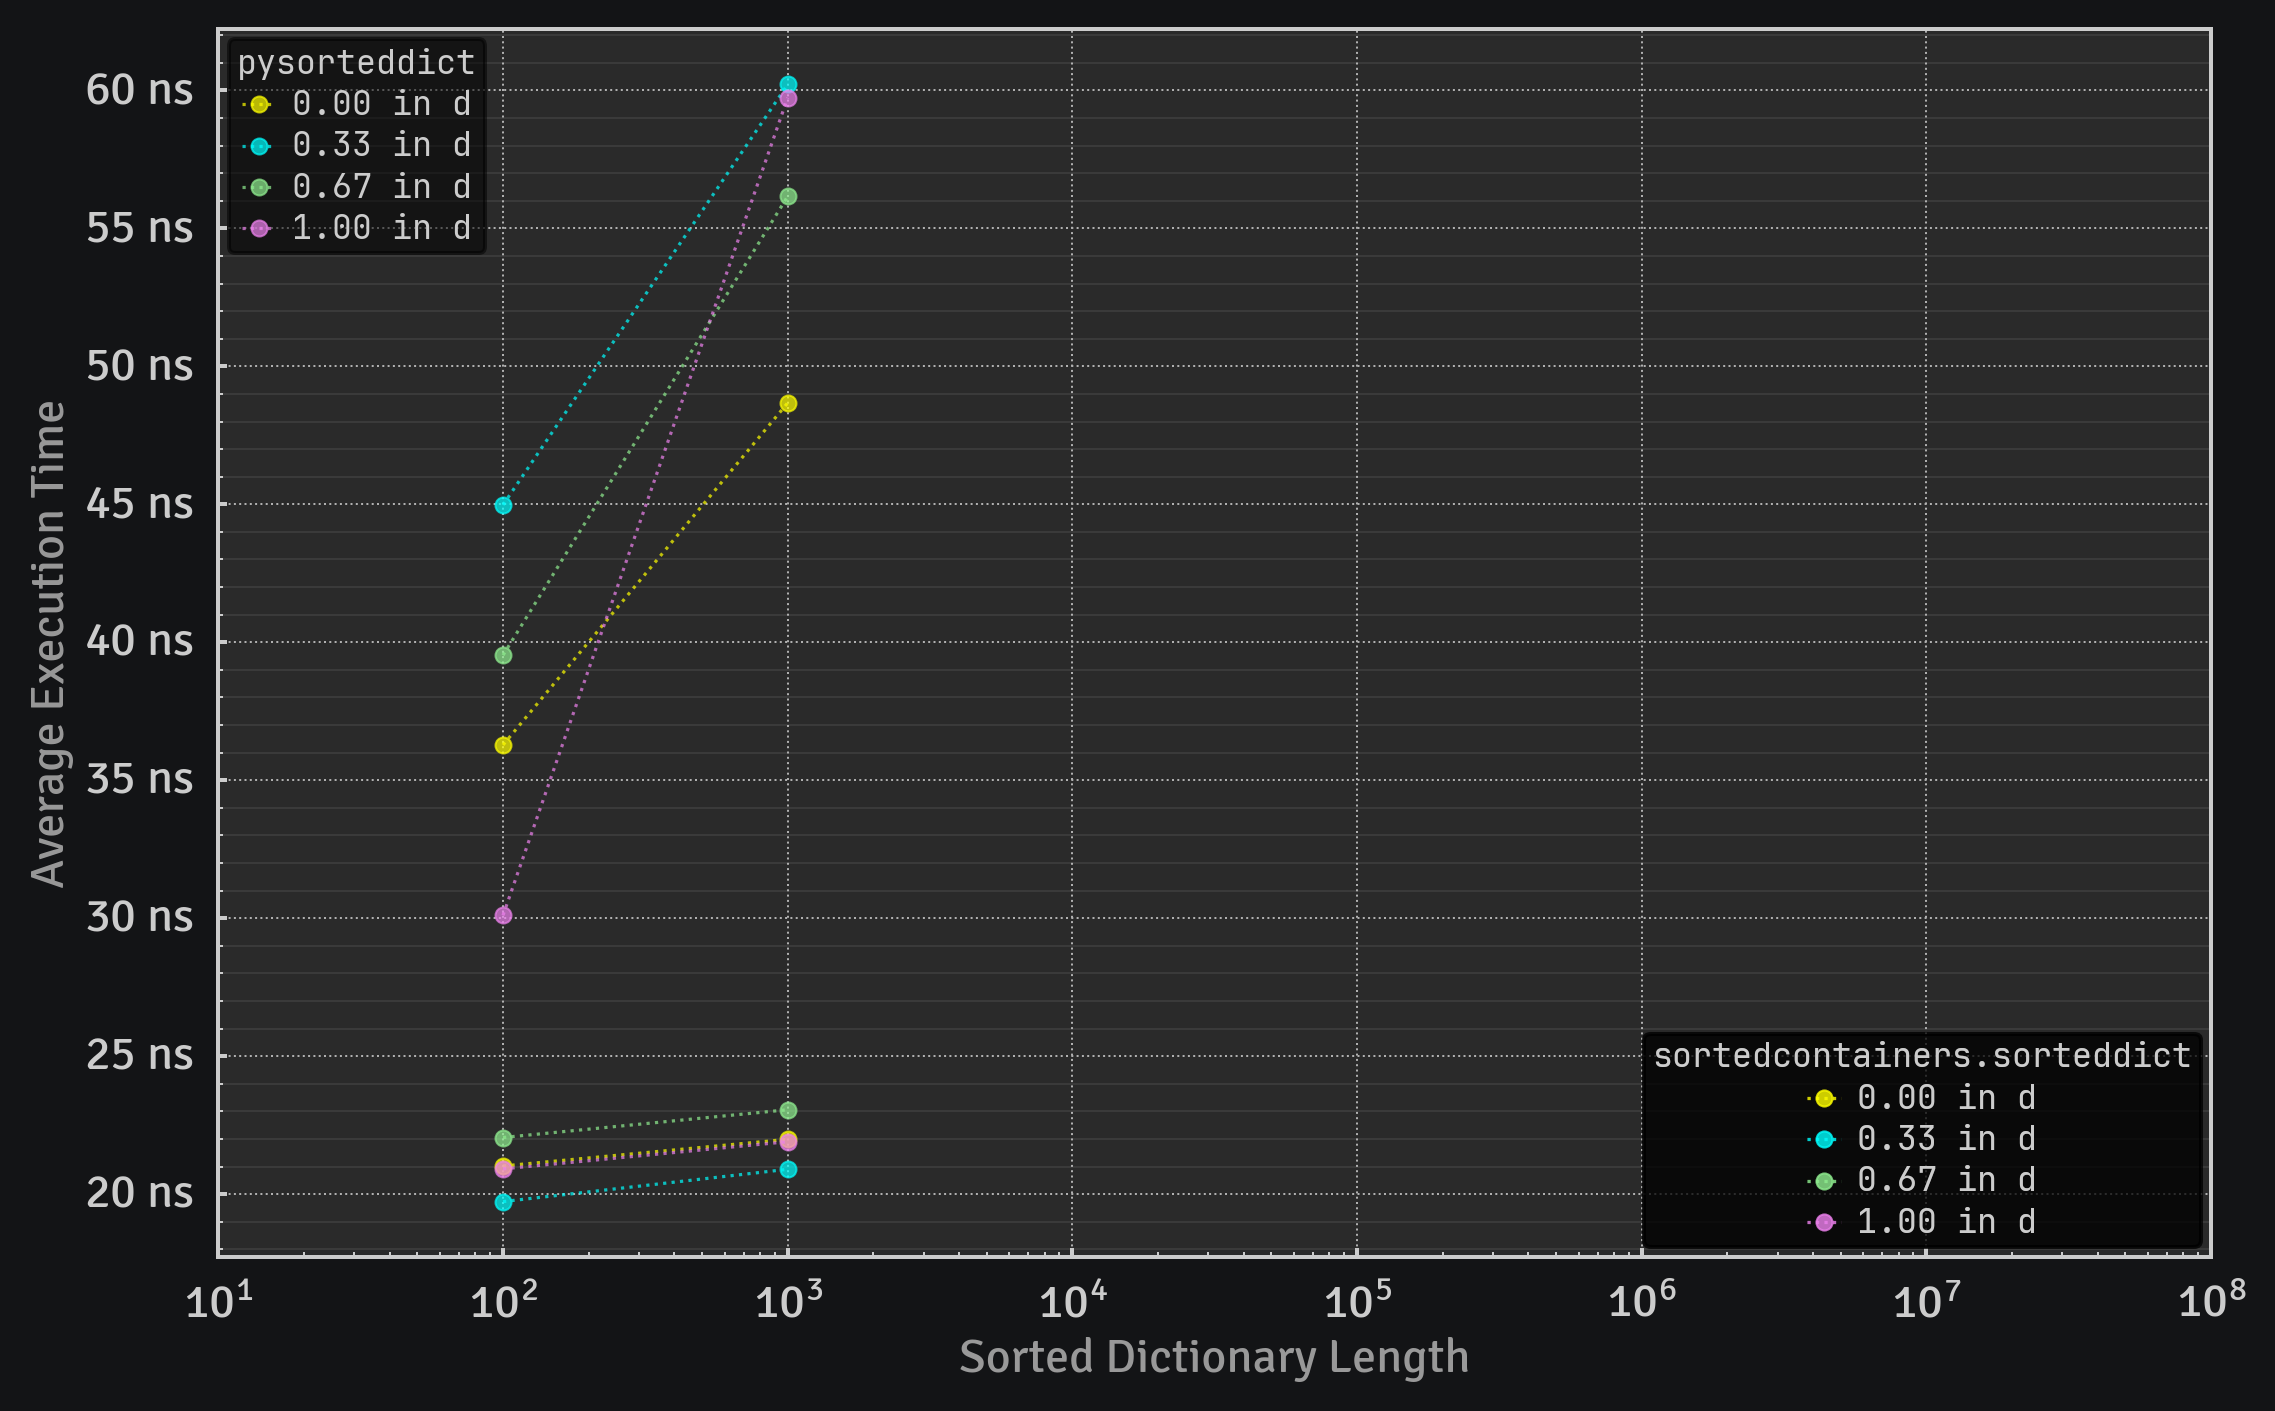

In [8]:
for styler in stylers:
    display(styler)
plot(stylers, name="contains", yunit="ns")

# `setitem`

In [ ]:
def set_del(d: SortedDict, keys: list[float]):
    for key in keys:
        d[key] = None
    for key in keys:
        del d[key]


keys_lens = [33, 67, 100]
df = pd.DataFrame(index=sorted_dict_lens, columns=[f"set_del(d, keys_{keys_len})" for keys_len in keys_lens])
for i, sorted_dict_len in enumerate(sorted_dict_lens):
    for j, keys_len in enumerate(keys_lens):
        d = setup(sorted_dict_len)
        keys = [random.random() for _ in range(keys_len)]
        %timeit -v bench set_del(d, keys)
        df.iat[i, j] = bench.average * 1e6

In [ ]:
display(df.T)
plot(df, name="setitem", yunit="μs")

# `iter`

In [ ]:
df = pd.DataFrame(index=sorted_dict_lens, columns=["for _ in d: pass", "for _ in reversed(d): pass"])
for i, sorted_dict_len in enumerate(sorted_dict_lens):
    d = setup(sorted_dict_len)
    %timeit -v bench for _ in d: pass
    df.iat[i, 0] = bench.average
    %timeit -v bench for _ in reversed(d): pass
    df.iat[i, 1] = bench.average

In [ ]:
display(df.T)
plot(df, logy=True, name="iter")